# Introducción

Los mercados bursátiles arrancaron marzo de 2025 con turbulencias. Cambios macroeconómicos abruptos e incertidumbre geopolítica han sacudido a los inversionistas, generando una búsqueda frenética de activos refugio. Sin embargo, en medio del caos, algunos sectores siguen atrayendo miradas, y uno de los más intrigantes es el farmacéutico.

Como químico y científico de datos, me resulta fascinante analizar esta industria en tiempos de incertidumbre. Por un lado, es un mercado con gran potencial de crecimiento para los inversores. Por otro, su volatilidad es legendaria, influenciada por regulaciones cambiantes, resultados de ensayos clínicos y desarrollos inesperados en la investigación de nuevos medicamentos. En otras palabras, un terreno fértil para el análisis predictivo.

Aquí es donde la ciencia de datos entra en juego. En este proyecto, aplicamos técnicas avanzadas de series temporales para predecir el valor de cierre de una acción farmacéutica particularmente interesante: NVO. El objetivo es explorar si los modelos de predicción pueden aportar valor en la toma de decisiones estratégicas dentro del mundo financiero.

⚠️ Aviso importante: Este proyecto NO es una recomendación de inversión. Si planeas invertir, haz tu propia investigación y toma decisiones informadas.

# Tabla de contenidos

1. [Importar](#Importar)
2. [Data Scraping](#Data-Scraping)
3. [Análisis de Datos Exploratorio o EDA](#Análisis-de-Datos-Exploratorio-o-EDA)
4. [Data Wrangling](#Data-Wrangling)
5. [Feature Engineering](#Feature-Engineering)
6. [Modelado](#Modelado)
7. [Guardar Modelo](#Guardar-Modelo)
8. [Evaluar Modelo](#Evaluar-Modelo)
9. [Conclusión](#Conclusión)

# Importar

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from datetime import datetime, date
import seaborn as sns

# Data Scraping

In [2]:
ticker='NVO'
end_date = date(2025, 3, 14)
start_date = date(2017, 1, 1)

In [3]:
data = yf.download(ticker, start=start_date, end=end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


# Análisis de Datos Exploratorio o EDA

In [4]:
display(data.tail(10))

Price,Close,High,Low,Open,Volume
Ticker,NVO,NVO,NVO,NVO,NVO
Date,,,,,
2025-02-28,90.650002,90.720001,89.379997,89.860001,5962500
2025-03-03,89.370003,90.739998,89.000000,90.660004,4810900
2025-03-04,87.500000,88.650002,86.330002,88.300003,5203600
2025-03-05,90.860001,91.900002,90.290001,91.500000,8011700
2025-03-06,88.040001,89.029999,87.459999,87.949997,5450900
2025-03-07,87.169998,88.550003,86.349998,88.370003,5278200
2025-03-10,78.949997,80.699997,78.300003,79.809998,12603400
2025-03-11,78.110001,79.269997,77.000000,78.879997,7433500


In [5]:
data.info()
print()
data.columns

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2060 entries, 2017-01-03 to 2025-03-13
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (Close, NVO)   2060 non-null   float64
 1   (High, NVO)    2060 non-null   float64
 2   (Low, NVO)     2060 non-null   float64
 3   (Open, NVO)    2060 non-null   float64
 4   (Volume, NVO)  2060 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 96.6 KB



MultiIndex([( 'Close', 'NVO'),
            (  'High', 'NVO'),
            (   'Low', 'NVO'),
            (  'Open', 'NVO'),
            ('Volume', 'NVO')],
           names=['Price', 'Ticker'])

In [6]:
print(data.index.dtype)

datetime64[ns]


Se observa que al mostrar los primeros 10 registros en los datos recolectados hay fechas faltantes, correspondientes a 2017-01-07 y 2017-01-08, mismos que podrían corresponder a fines de semana o festivos. Sin embargo no hay valores ausentes en el dataframe.

## Visualización del histórico de precios de cierre de la acción

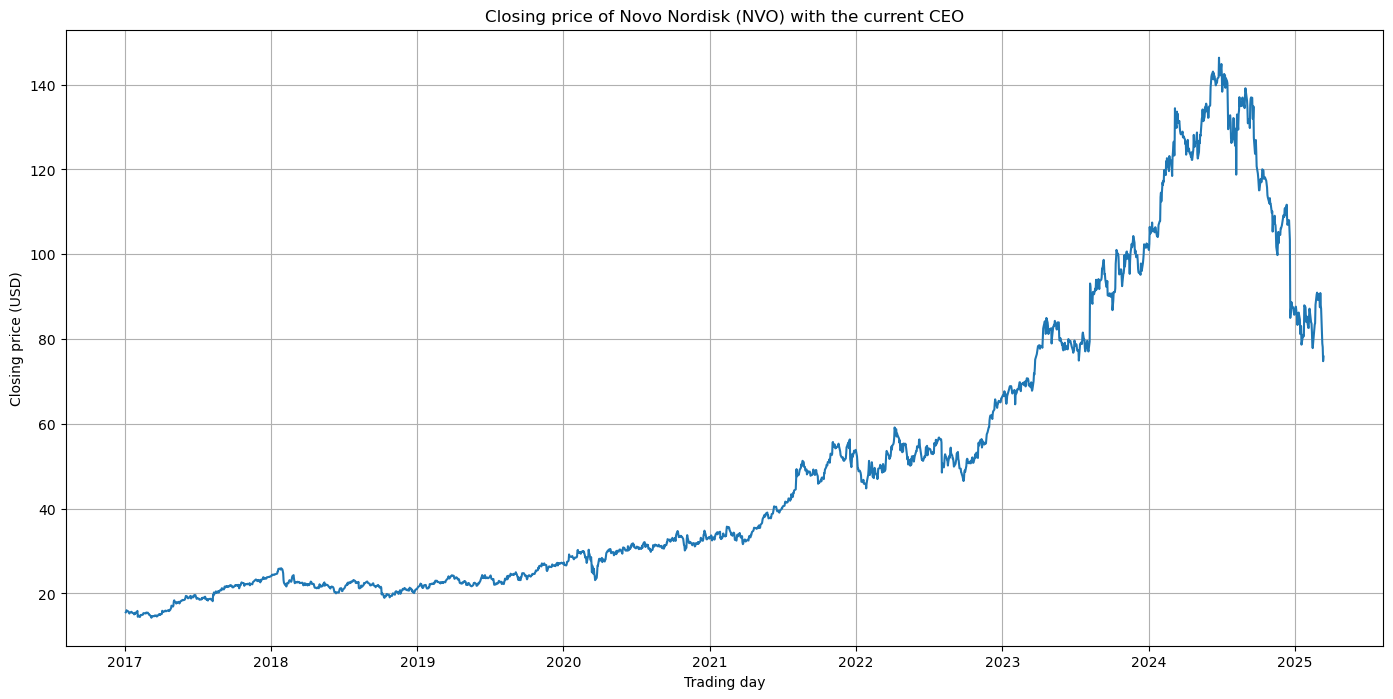

In [7]:
plt.figure(figsize=(17, 8))
plt.plot(data[('Close', 'NVO')])
plt.title('Closing price of Novo Nordisk (NVO) with the current CEO')
plt.ylabel('Closing price (USD)')
plt.xlabel('Trading day')
plt.grid(True)
plt.show()

El métod .info() muestra que no hay valores ausentes ya que se cuenta con 2057 registros estructurados en 5 columnas con valores tipo float, mismos que no muestran valores ausentes.
También se observó que los titúlos de las columnas estan en un formato multiindex confuso, por lo que se decidió cambiarlos al formato snakecase.

# Data Wrangling

## Dar formato snakecase

In [8]:
data.columns = data.columns.droplevel(level=1) # Eliminar el nivel 'Tricker'
data.columns = data.columns.str.lower()
data.columns.name = None # Eliminar el nivel 'Price'

In [9]:
data.columns

Index(['close', 'high', 'low', 'open', 'volume'], dtype='object')

## Comprobar estacionaridad de la serie temporal

Se realizó una comprobación visual de la serie temporal así como la prueba estadística utilizando la prueba de Dickey-Fuller

In [10]:
# Asegurarse de que los datos precio de cierre corresponden a una serie
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    '''
    Esta función esta pensada para:
    - Graficar los precios de cierre de la acción vs tiempo
    - Mostrar la autocorrelación, tal que si el resultado sale de las bandas de confianza muestra una pobre autocorrelación
    - Mostrar la autocorrelación parcial, si el resultado sale de las bandas de confianza muestra una pobre autocorrelación parcial
    - Realizar el test estadístico de Dickey-Fuller

    Todo lo anterior ayuda a la corroboración visual y estadística de la estacionariedad de la serie temporal analizada
    '''
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

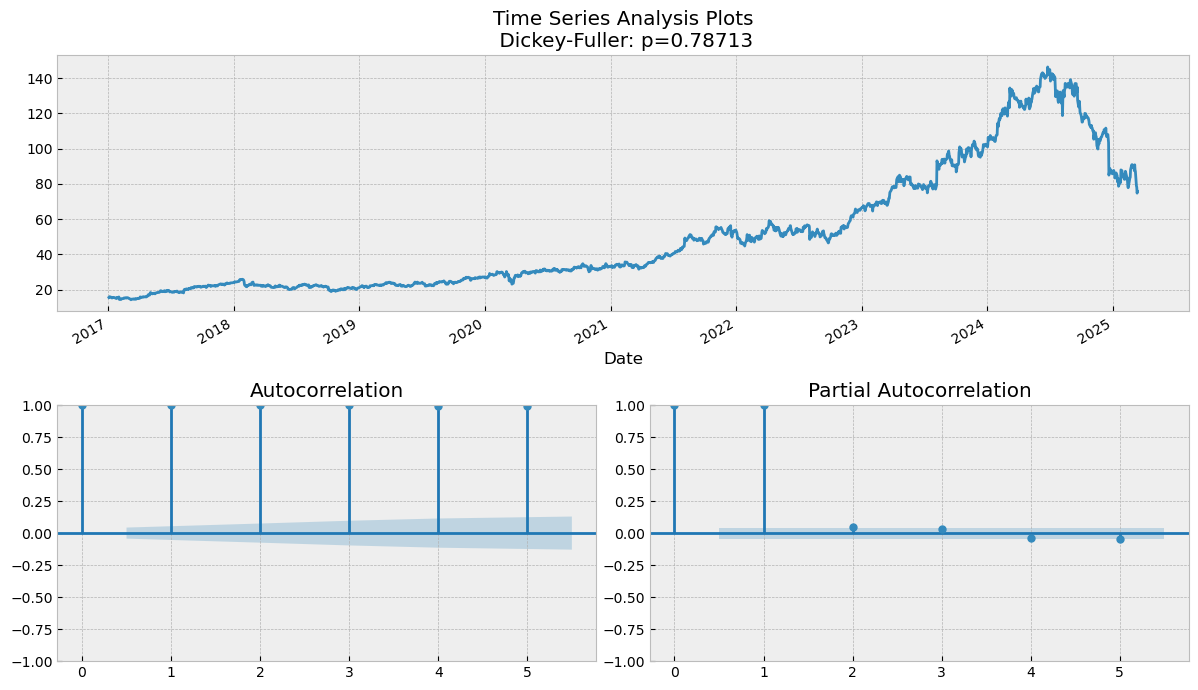

In [11]:
tsplot(data.close, lags=5)

La serie no es estacionaria como se muestra en la prueba estadística al mostrar valores fuera de las bandas que indicarian que la tendencia, varianza y covarianza cambian y no siguen un patrón, este se puede observar en el valor de p alejado de 0. Al no ser una serie estacionaria se preparan los datos para utilizar un modelo AutoARIMA para la creación del modelo predictivo.

## Segmentación

En este problema en particular no se segmentan los dato usando ```train_test_split``` debido a que se creará un modelo AutoARIMA que al utilizar una ventana expandida para realizar la validación cruzada.

Así, la variable ```y```  contiene toda la serie temporal y la función ```evaluate()``` se encarga automáticamente de dividir los datos en ```y_train``` y ```y_test``` en cada iteración de la __validación cruzada__. Esto ocurre a groso modo de la siguiente manera:

* ```ExpandingWindowSplitter``` maneja la partición interna de los datos
* En cada iteración, se toma una parte de ```y``` como ```y_train``` (según la ```initial_window```).
* Otra sección, se reserva como parte de ```y_test``` (según ```fh```  **forecasting horizon**).
* Se entrena el modelo en ```y_train``` y se predice ```y_test```.

Por lo que no es necesario separar manualmente ```y_train``` y ```y_test```, ya que ```evaluate()``` lo hace internamente.

In [12]:
display(data.head(10))

,close,high,low,open,volume
Date,,,,,
2017-01-03,15.556056,15.720625,15.469442,15.690310,9445800
2017-01-04,15.668654,15.716293,15.564716,15.642669,5143800
2017-01-05,16.049765,16.058426,15.876534,15.932834,4803800
2017-01-06,15.867867,15.928498,15.802907,15.919836,5227400
2017-01-09,15.807240,15.854878,15.659994,15.759601,3724600
2017-01-10,15.595033,15.716295,15.595033,15.647003,3082000
2017-01-11,15.426136,15.603697,15.248575,15.517083,4422000
2017-01-12,15.270224,15.317862,15.088333,15.127310,4415600
2017-01-13,15.473775,15.569052,15.400153,15.486767,4629000


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2060 entries, 2017-01-03 to 2025-03-13
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   2060 non-null   float64
 1   high    2060 non-null   float64
 2   low     2060 non-null   float64
 3   open    2060 non-null   float64
 4   volume  2060 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 96.6 KB


In [14]:
# Segmentar las fechas del 2025-03-11 al 2025-03-13 para comprobar predicciones

start_real = '2025-03-11'
end_real = '2025-03-13'

y_real = data.loc[start_real:end_real, ['close']]
display(y_real.head())

,close
Date,
2025-03-11,78.110001
2025-03-12,74.790001
2025-03-13,75.889999


In [15]:
# Segmentar las fechas desde 2017-01-03  hasta 2025-03-10

start_pred = '2017-01-03'
end_pred = '2025-03-10'

y = data.loc[start_pred:end_pred, ['close']]
display(y.head(10))

,close
Date,
2017-01-03,15.556056
2017-01-04,15.668654
2017-01-05,16.049765
2017-01-06,15.867867
2017-01-09,15.807240
2017-01-10,15.595033
2017-01-11,15.426136
2017-01-12,15.270224
2017-01-13,15.473775


# Feature Engineering

Se aseguró que el índice de la serie temporal sea del tipo datetime y se le asigno una frecuencia diaria de la serie temporal ```'D'```.

Esto generaró que se creen registros nuevos si es que no se sigue una candelarización diaria, colocando en el primer registro el valor correspondiente y en el resto si ese fuera el caso valores nulos. Por lo que se debe de utilizar el parámetro ```ffill``` del métod ```.asfreq()``` para indicar que se llenen los valores nulos siguientes con los del último registro, de tal forma que por ejemplo, los registros de los días viernes se usaran para llenar los valores de los sábados y domingos en los que no se labora en el mercado bursátil.

In [16]:
y = data['close']
print(y.index.freq)

None


In [17]:
# Establece la frecuencia a la serie temporal 'D' para días
y = y.asfreq('D', method='ffill')

In [18]:
# Comprobación de asignación de frecuencia a serie temporal
print(y.index.freq)

<Day>


## Comprobar valores ausentes

In [19]:
# Asegurarse que el índice sea tipo datetime
print('La cuenta de valores ausentes es:', y.isna().sum())

La cuenta de valores ausentes es: 0


In [20]:
y = y.dropna()

In [21]:
print('La cantindad de valores ausentes actualizada es de:', y.isna().sum())

La cantindad de valores ausentes actualizada es de: 0


# Modelado

In [22]:
forecaster = AutoARIMA(sp=9) # 9 años analizados

# Configuración de validación cruzada

cv = ExpandingWindowSplitter(
    step_length=30, # Cada paso tendrá 30 periodos
    fh=list(range(1,31)), # Horizonte de predicción de 30 periodos
    initial_window=40 # La primera ventana de entrenamiento tendrá 40 periodos
)

In [23]:
# Evaluar con validación cruzada
cv_data = evaluate(
    forecaster=forecaster,
    y=y,
    cv=cv,
    strategy='update', # Actualizar el modelo en cada iteración
    return_data=True, # Regresa los datos de la evaluación
    error_score="raise"
)

c:\Users\juano\anaconda3\envs\series_temporales\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\juano\anaconda3\envs\series_temporales\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\juano\anaconda3\envs\series_temporales\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\juano\anaconda3\envs\series_temporales\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\juano\anaconda3\envs\series_temporales\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: '

## Guardar modelo

El proceso de validación cruzada con evaluate() entrena varias versiones del modelo en diferentes subconjuntos de datos, pero no guarda un modelo final ajustado sobre toda la serie temporal.

Por eso, para poder predecir (predict(fh)), faltaría realizar el entrenamiento con .fit sobre toda la serie temporal y.

In [24]:
forecaster.fit(y)

c:\Users\juano\anaconda3\envs\series_temporales\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\juano\anaconda3\envs\series_temporales\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\juano\anaconda3\envs\series_temporales\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\juano\anaconda3\envs\series_temporales\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\juano\anaconda3\envs\series_temporales\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: '

AutoARIMA(sp=9)

In [ ]:
fechas = '2025-03-11', '2025-03-12', '2025-03-13'
# fh = pd.to_datetime([start_real, end_real])   # Predicción para los próximos 3 días
fh = pd.to_datetime(fechas)
y_pred = forecaster.predict(fh=fh)
print(y_pred)  # Mostrar los valores predichos


2025-03-11    79.259255
2025-03-12    78.167023
2025-03-13    74.949944
Name: close, dtype: float64


# Evaluar Modelo

In [26]:
# Calcular el MAPE
mape = mean_absolute_percentage_error(y_real, y_pred)

print(f"MAPE del modelo: {mape:.3%}")  # Se muestra como porcentaje

MAPE del modelo: 2.408%


# Conclusión

El modelo es capaz de predecir los precios de cierre de las acciones con un mape de 2.408%. Ejemplificando, si la acción de NVO valiera $100 USD la predicción arrojaría valores ente $97.592 USD y $102.408 USD aun en un escenario altamente fluctuante y un sector inherentemente volatil.